## Session 42 
Aug 27, 2021
### Neural Net for Multiple instances

In [1]:
import numpy as np

In [244]:
class BinaryCrossEntropy:

    def __call__(self, ytrue, ypred):
        """ 
        ytrue: column vector (m,1)
        ypred: column vector (m,1)
        Returns: Loss (1,1)
        """
        assert ytrue.shape == ypred.shape, f"shape mismatch ytrue {ytrue.shape} != ypred {ypred.shape}"
        return -np.sum( ytrue*np.log(ypred + 1e-10) + (1-ytrue)*np.log(1-ypred + 1e-10) )

    def grad_input(self, y, ypred):
        grad = np.zeros(ypred.shape)
        ix0 = (y==0).reshape(-1,)
        ix1 = (y==1).reshape(-1,)
        grad[ix0,:] = 1/(1-ypred[ix0,:])
        grad[ix1,:] = -1/ypred[ix1,:]
        return grad.reshape(-1,1,1)

In [2]:
class Sigmoid:

    def __call__(self, X):
        return self.eval(X)

    def eval(self, X):
        return 1/((np.e**-X) + 1)

    def grad_input(self, X):
#         return np.identity(X.shape[1]) * self.eval(X)*(1-self.eval(X))
        I = np.identity(X.shape[1])
        b = self.eval(X)*(1-self.eval(X)) # same shape as X
        return np.einsum('ij,mi->mij', I, b)

In [12]:
# m = 2, no_of_features=2
X = np.arange(1,7).reshape(3,2)
print(X, X.shape)

I = np.identity(X.shape[1])
print("identity shape:", I.shape)
print(I)

s = Sigmoid()
b = s.eval(X)*(1-s.eval(X))
print(b) # same shape as X

ans = np.einsum('ij,mi->mij', I, b)
print(ans)
print(ans.shape)

[[1 2]
 [3 4]
 [5 6]] (3, 2)
identity shape: (2, 2)
[[1. 0.]
 [0. 1.]]
[[0.19661193 0.10499359]
 [0.04517666 0.01766271]
 [0.00664806 0.00246651]]
[[[0.19661193 0.        ]
  [0.         0.10499359]]

 [[0.04517666 0.        ]
  [0.         0.01766271]]

 [[0.00664806 0.        ]
  [0.         0.00246651]]]
(3, 2, 2)


In [14]:
class Dot:

    def __init__(self, input_size, units):
        self.W = np.random.randn(input_size, units)
        self.b = np.random.randn(1, units)

    def __call__(self, X):
        return self.eval(X)

    def eval(self, X):
        return X.dot(self.W) + self.b

    def grad_input(self, X):
        return np.stack([self.W.T]*X.shape[0], axis=0) 
        #return self.W.T

    def grad_w(self, X):
        I = np.identity(self.b.shape[1])
        m1 = np.stack([I]*self.W.shape[0], axis=1)
        #print(g.shape)
        #for i in range(g.shape[0]):
        #    g[i] *= X[0][i]
        #return np.transpose(g, [1,0,2])
        return np.einsum('ijk,mj->mijk', m1, X)

    def grad_b(self):
        return np.stack([np.identity(self.b.shape[1])]*X.shape[0], axis=0)
        #return np.identity(self.b.shape[1])
    
    def get_parameter_shape(self):
        return self.W.shape, self.b.shape


In [24]:
# layer 1 # grad_w
d = Dot(2,3)
print(d.W.shape, d.b.shape)
I = np.identity(d.b.shape[1])
m1 = np.stack([I]*d.W.shape[0], axis=1)

print(m1.shape)
# print(m1)

X = np.arange(1,5).reshape(-1,2)
print(X.shape)

dI_dw = np.einsum('ijk,mj->mijk', m1, X)
print(dI_dw)
print(dI_dw.shape)

(2, 3) (1, 3)
(3, 2, 3)
(2, 2)
[[[[1. 0. 0.]
   [2. 0. 0.]]

  [[0. 1. 0.]
   [0. 2. 0.]]

  [[0. 0. 1.]
   [0. 0. 2.]]]


 [[[3. 0. 0.]
   [4. 0. 0.]]

  [[0. 3. 0.]
   [0. 4. 0.]]

  [[0. 0. 3.]
   [0. 0. 4.]]]]
(2, 3, 2, 3)


In [247]:
I = np.identity(3) 
X = np.stack( [np.array([2, 3, 4])]*5 )
m1 = np.stack([I]*2, axis=1)

print(X.shape)
ans = []
for x in X:
    ans.append(m1*x)
ans = np.array(ans)
ans.shape

(5, 3)


(5, 3, 2, 3)

In [29]:
class Dense:

    def __init__(self, input_size, activation, units):
        """
        input_size: no. of neurons in previous layer
        activation: some activation funtion
        units: no. of neurons in current layer 
        """
        self.activation = activation
        self.units = units
        self.dot = Dot(input_size, units)

    def eval(self, X):
        return self.activation(self.dot(X))

    def grad_input(self, X):
        g1 = self.activation.grad_input( self.dot(X) )
        g2 = self.dot.grad_input(X)
        #return g1.dot(g2)
        return np.einsum('mij,mjk->mik', g1, g2)

    def grad_parameters(self, X):
        da_dI = self.activation.grad_input(self.dot(X))
        dI_dw = self.dot.grad_w(X)
        #da_dw = da_dI.dot(dI_dw)
        da_dw = np.einsum('mij,mjkl->mikl', da_dI, dI_dw)

        dI_db = self.dot.grad_b()
        #da_db = da_dI.dot(dI_db)
        print(da_dI.shape, dI_dw.shape, dI_db.shape)
        da_db = np.einsum('mij,mjk->mik',  da_dI, dI_db)
        return da_dw, da_db
        
    def update(self, grad, optimizer):
        """ grad: (dL_dwi, dL_dbi)"""
        self.dot.W = optimizer.minimize(self.dot.W, grad[0])
        self.dot.b = optimizer.minimize(self.dot.b, grad[1])
        
    def get_parameter_shape(self):
        return self.dot.get_parameter_shape()
    
    def get_total_parameters(self):
        w_shape, b_shape = self.dot.get_parameter_shape()
        return np.prod(w_shape) + np.prod(b_shape)

In [31]:

layer1 = Dense(2, Sigmoid(), 3)
dl1_dw, dl1_db = layer1.grad_parameters(X)
print(dl1_dw.shape, dl1_db.shape)
# print(dl1_db)
print(dl1_dw)

(2, 3, 3) (2, 3, 2, 3) (2, 3, 3)
(2, 3, 2, 3) (2, 3, 3)
[[[[0.24999903 0.         0.        ]
   [0.49999805 0.         0.        ]]

  [[0.         0.10802761 0.        ]
   [0.         0.21605521 0.        ]]

  [[0.         0.         0.17976398]
   [0.         0.         0.35952796]]]


 [[[0.7375204  0.         0.        ]
   [0.98336053 0.         0.        ]]

  [[0.         0.74563211 0.        ]
   [0.         0.99417615 0.        ]]

  [[0.         0.         0.66954043]
   [0.         0.         0.89272057]]]]


In [36]:
w3 = np.arange(1,3).reshape(2,1)
print(w3.shape)
print(w3)
dL_dw = w3.reshape(1,2,1)
print(dL_dw, dL_dw.shape)
dL_dw[0]

(2, 1)
[[1]
 [2]]
[[[1]
  [2]]] (1, 2, 1)


array([[1],
       [2]])

In [249]:
class GradientDescentOptimizer:

    def __init__(self, lr):
        self.lr = lr

    def minimize(self, w, grad):
        assert w.shape == grad.shape, f"Shape mismatch w shape {w.shape} != grad shape {grad.shape}"
        w = w-self.lr*grad
        return w

In [216]:
class Sequential:

    def __init__(self, loss):
        self.layers = []
        self.loss = loss

    def add(self, layer):
        self.layers.append(layer)

    def forward_propagation(self, X):
        output = X
        outputs = []
        grads = []
        for layer in self.layers:
            g = {}
            g['input'] = layer.grad_input(output)
            g['w'], g['b'] = layer.grad_parameters(output)
            grads.append(g)
            output = layer.eval(output)
            outputs.append(output)
        return outputs, grads

    def back_propagate(self, grads, outputs, y):
        grad_loss = self.loss.grad_input(y, outputs[-1]) # dL/dlast_layer_output
        for layer, grad in list(zip(self.layers, grads))[::-1]:
#             dL_dwi, dL_dbi = grad_loss.dot(grad['w']), grad_loss.dot(grad['b'])
#             print(grad_loss.shape, grad['w'].shape, grad['b'].shape, grad['input'].shape)
            dL_dwi = np.einsum('mij,mjkl->mikl', grad_loss, grad['w']).sum(axis=0)
            dL_dbi = np.einsum('mij,mjk->mik', grad_loss, grad['b']).sum(axis=0)
#             print(dL_dwi.shape, dL_dbi.shape)
            
            layer.update((dL_dwi[0], dL_dbi), self.optimizer)
#             grad_loss = grad_loss.dot(grad['input'])
            grad_loss = np.einsum('mij,mjk->mik', grad_loss, grad['input'])
            

    def fit(self, X, y, epochs, optimizer, learning_rate, verbose=1):
        self.optimizer = optimizer(learning_rate)
        for i in range(epochs):
            outputs, grads = self.forward_propagation(X)
            self.back_propagate(grads, outputs, y)
            if verbose==1:
                print(f"\rEpoch: {i+1} Loss: {self.loss(y, outputs[-1])}", end="")
        if verbose==0:
            print(f"Epoch: {i} Loss: {self.loss(y, outputs[-1])}")

    def eval(self, X):
        return self.forward_propagation(X)[0][-1]
    
    def summary(self):
        from tabulate import tabulate
        headers = ["#", "Layer Type", "W.shape", "b.shape", "Total parameters"]
        table = []
        total_p = 0
        for i, layer in enumerate(self.layers):
            w_shape, b_shape = layer.get_parameter_shape()
            p = layer.get_total_parameters() # total parameters of a layer
            table.append([i+1, layer.__class__.__name__, w_shape, b_shape, p])
            total_p += p
        print(tabulate(table, headers, tablefmt="pretty"))
        print("Total no. of model parameters", total_p)
        
    def predict(self, X):
        output = X
        for layer in self.layers:
            output = layer.eval(output)
        return output
    
    def accuracy(self, y, ypred):
        return (y==(ypred>0.5).astype('int')).mean()
            

## Data Generation

In [210]:
from sklearn.datasets import make_gaussian_quantiles
import matplotlib.pyplot as plt

X (200, 2) y: (200, 1)


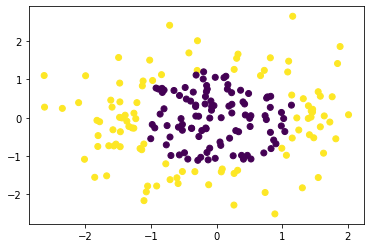

In [250]:
X, y = make_gaussian_quantiles(n_samples=200,n_classes=2)
y = y.reshape(-1,1)
print("X", X.shape, "y:", y.shape)

plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

## Model Creation

In [251]:
model = Sequential(BinaryCrossEntropy())
model.add(Dense(input_size = 2, activation=Sigmoid(), units=3))
model.add(Dense(input_size = 3, activation=Sigmoid(), units=2))
model.add(Dense(input_size = 2, activation=Sigmoid(), units=1))

In [252]:
model.summary()

+---+------------+---------+---------+------------------+
| # | Layer Type | W.shape | b.shape | Total parameters |
+---+------------+---------+---------+------------------+
| 1 |   Dense    | (2, 3)  | (1, 3)  |        9         |
| 2 |   Dense    | (3, 2)  | (1, 2)  |        8         |
| 3 |   Dense    | (2, 1)  | (1, 1)  |        3         |
+---+------------+---------+---------+------------------+
Total no. of model parameters 20


In [253]:
ypred = model.predict(X)
print("Ypred", ypred.shape)
print("Loss", model.loss(y, ypred))
print("Accuracy", model.accuracy(y, ypred))

Ypred (200, 1)
Loss 150.28302650867514
Accuracy 0.5


In [258]:
model.fit(X, y, epochs=100, optimizer=GradientDescentOptimizer, learning_rate=0.005, verbose=1)

Epoch: 100 Loss: 18.898655733862157

In [259]:
ypred = model.predict(X)
model.accuracy(y,ypred)

0.98